# Using Nano-AutoGrads to classify MINIST handwritten digits

In [1]:
!pip install nano-autograds

In [2]:
import os
os.environ['NANO-AUTOGRAD_COMPUTE'] = 'cupy'
import cupy as np

import autograd
import autograd.torch.nn as nn
import autograd.torch.nn.functional as F
from matplotlib import pyplot as plt


### Load MNIST dataset

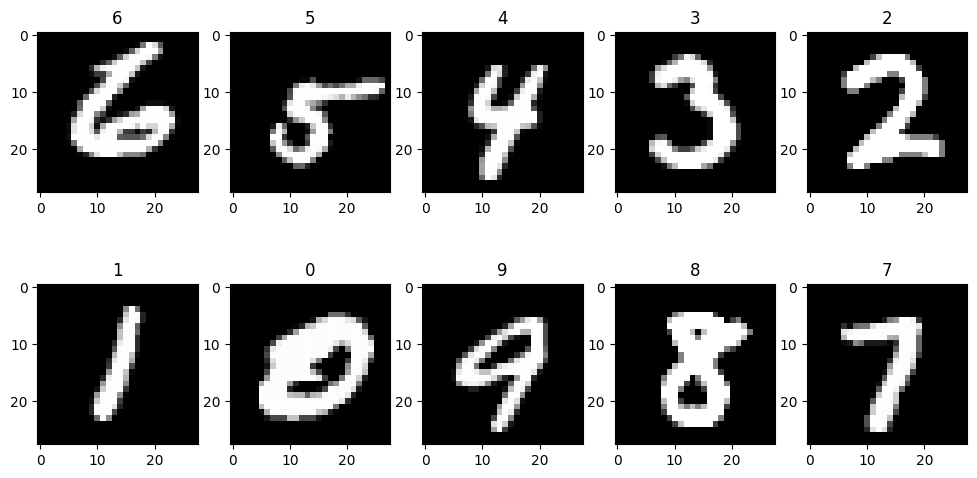

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, parser='liac-arff')
y = y.astype(np.int64)

plt.rcParams['figure.figsize'] = (12,6)
for i in range(1, 11):
  plt.subplot(2,5,i)
  plt.imshow(X[-i].reshape(28, 28),cmap=plt.get_cmap('gray'))
  plt.title(y[-i])

### Scale images and split dataset into train / test sets

In [4]:
seed = 1717
np.random.seed(seed)

# Scale images to the [0, 1] range
X /= 255.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
print(f"{X_train.shape=} {X_test.shape=} {y_train.shape=} {y_test.shape=}")

inputs_t = autograd.Tensor(X_test)
labels_t = autograd.Tensor(np.eye(10)[y_test])
print(f"{labels_t.data[0]=}")

X_train.shape=(56000, 784) X_test.shape=(14000, 784) y_train.shape=(56000,) y_test.shape=(14000,)
labels_t.data[0]=array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])


In [5]:
num_epochs = 10
batch_size = 128


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 1568, name='l1')
        self.l2 = nn.Linear(1568, 392, name='l2')
        self.l3 = nn.Linear(392, 10, name='l3')

    def forward(self, x):
        z = F.relu(self.l1(x))
        z = F.relu(self.l2(z))
        out = F.log_softmax(self.l3(z))
        return out

model = Model()
optimizer = autograd.optim.SGD(model.parameters(), lr=5e-2, weight_decay=1e-4)
scheduler = autograd.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.75, total_iters=num_epochs)

num_batches = -(-X_train.shape[0] // batch_size)

### Train model

In [6]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for k in range(num_epochs):

    accuracy = 0
    train_loss = 0
    for batch in range(num_batches):
        inputs = autograd.Tensor(X_train[batch * batch_size:(batch + 1) * batch_size])
        labels = autograd.Tensor(np.eye(10)[y_train[batch * batch_size:(batch + 1) * batch_size]])

        # Forward
        preds = model(inputs)
        loss = F.nll_loss(preds, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()

        # Update (SGD)
        optimizer.step()

        accuracy += int(np.count_nonzero(np.argmax(preds.data, axis=-1) == np.argmax(labels.data, axis=-1)))
        train_loss += loss.data.item()

    scheduler.step()

    accuracy /= X_train.shape[0]
    train_loss /= X_train.shape[0]
    train_accuracies.append(accuracy)
    train_losses.append(train_loss)

    with autograd.no_grad():
        preds_t = model(inputs_t)
        loss_t = F.nll_loss(preds_t, labels_t).data.item()

    accuracy_t = int(np.count_nonzero(np.argmax(preds_t.data, axis=-1) == np.argmax(labels_t.data, axis=-1))) / X_test.shape[0]
    test_accuracies.append(accuracy_t)
    test_losses.append(loss_t)

    print(f"Epoch {k+1} loss {train_loss:.6f}, accuracy {accuracy * 100:.6f}%  test loss {loss_t:.6f}, test accuracy {accuracy_t * 100:.6f}% lr {optimizer.lr:.6f}")


Epoch 1 loss 0.006730, accuracy 78.282143%  test loss 0.379793, test accuracy 88.792857% lr 0.048750
Epoch 2 loss 0.002528, accuracy 90.760714%  test loss 0.295079, test accuracy 91.392857% lr 0.047500
Epoch 3 loss 0.002071, accuracy 92.466071%  test loss 0.249191, test accuracy 92.842857% lr 0.046250
Epoch 4 loss 0.001766, accuracy 93.571429%  test loss 0.215430, test accuracy 93.857143% lr 0.045000
Epoch 5 loss 0.001529, accuracy 94.408929%  test loss 0.189770, test accuracy 94.650000% lr 0.043750
Epoch 6 loss 0.001342, accuracy 95.053571%  test loss 0.169964, test accuracy 95.192857% lr 0.042500
Epoch 7 loss 0.001194, accuracy 95.648214%  test loss 0.154660, test accuracy 95.614286% lr 0.041250
Epoch 8 loss 0.001074, accuracy 96.071429%  test loss 0.142427, test accuracy 95.942857% lr 0.040000
Epoch 9 loss 0.000974, accuracy 96.444643%  test loss 0.132554, test accuracy 96.178571% lr 0.038750
Epoch 10 loss 0.000891, accuracy 96.730357%  test loss 0.124461, test accuracy 96.421429% l

### Plot metrics

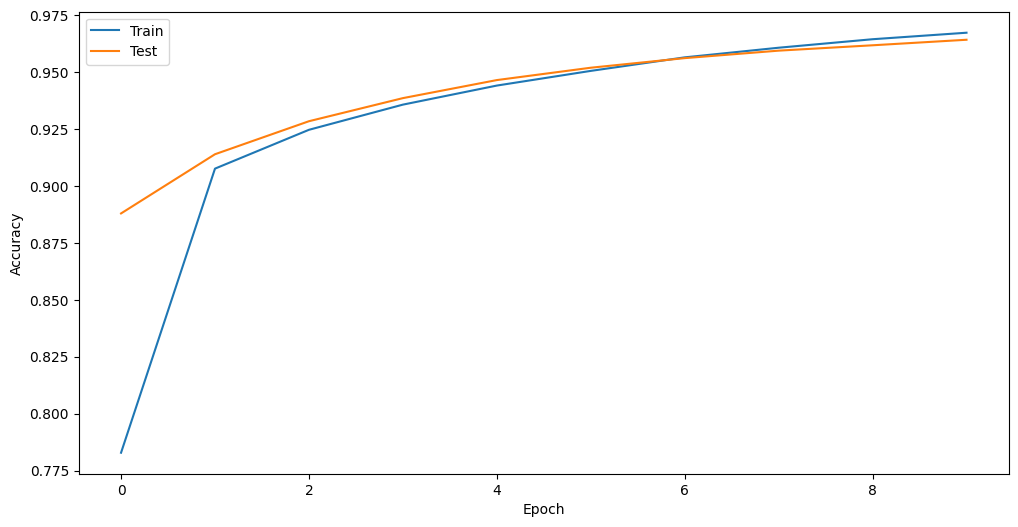

In [9]:
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


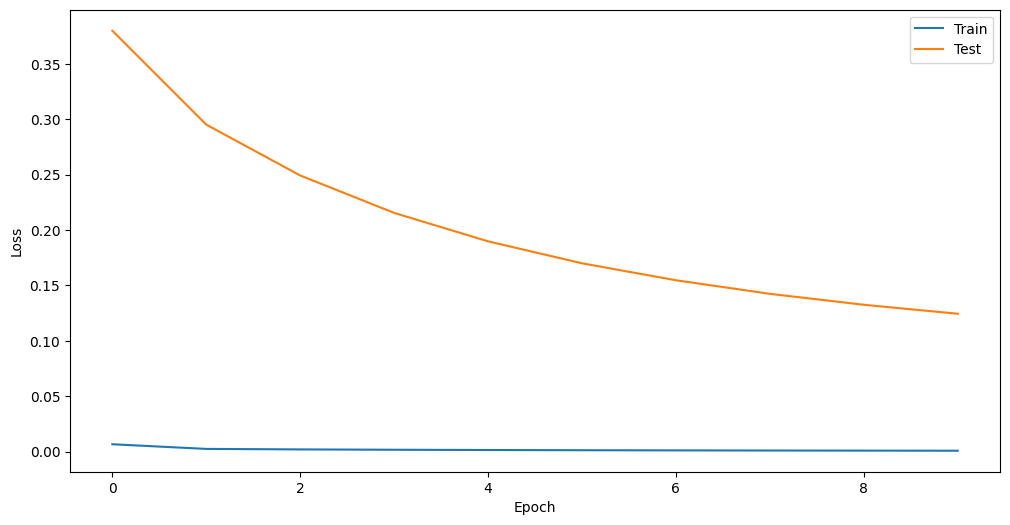

In [10]:
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Model predictions

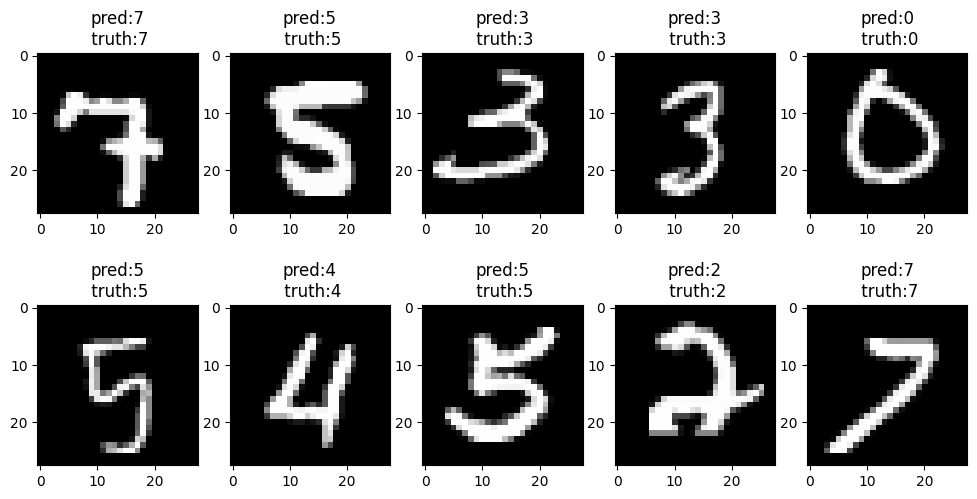

In [8]:
predicted_labels = [pred.item() for pred in np.argmax(preds_t.data, axis=-1)]
plt.rcParams['figure.figsize'] = (12,6)
for i in range(0, 10):
  plt.subplot(2,5,i+1)
  plt.imshow(X_test[i].reshape(28, 28),cmap=plt.get_cmap('gray'))
  plt.title(f"pred:{predicted_labels[i]}\n truth:{y_test[i]}")